In [1]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from math import pi, tanh

def complex_to_rgb(c: torch.Tensor):
    hue = c.angle().item() / (2 * pi)
    saturation = 1
    light = 0.9-0.8*tanh(c.abs().item())
    return colorsys.hls_to_rgb(hue, light, saturation)

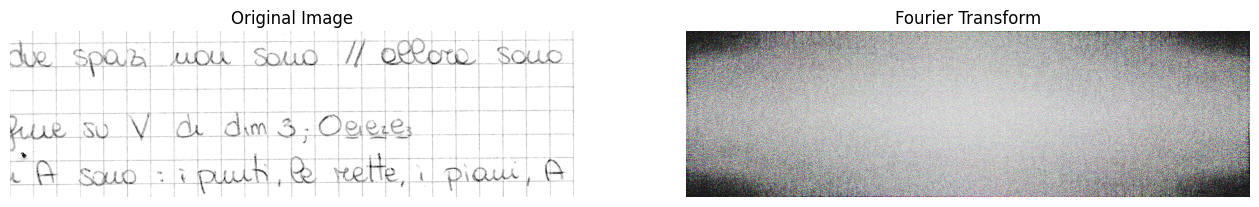

In [46]:
# leggo l'immagine
image_path = 'db/cutted_set/Author1/Author1_0025_02.png'

# carico l'immagine e la passo a torch
image = Image.open(image_path).convert('L')
image_torch = torch.from_numpy(np.array(image)).to('cuda')
image_torch_mean = image_torch.mean(dtype=torch.float32)
image_torch = image_torch - image_torch_mean
image_torch = image_torch / image_torch.var()**0.5

# analisi di fourier usando fft2d
image_fft = torch.fft.fft2(image_torch, norm='ortho').to('cpu')

# devo ideare una scala di colore che dato un numero complesso mi dia un colore
image_fft_rgb = torch.zeros(image_fft.shape + (3,))
for i in range(image_fft.shape[0]):
    for j in range(image_fft.shape[1]):
        image_fft_rgb[i, j] = torch.tensor(complex_to_rgb(image_fft[i, j]))

# visualizzo le due immagini a confronto in una grande figura
plt.figure(figsize=(2*8, 1*8))
plt.subplot(1, 2, 1)
plt.imshow(image_torch.to('cpu'), cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(image_fft_rgb.to('cpu'), vmin=0, vmax=1)
plt.axis('off')
plt.title('Fourier Transform')
plt.savefig('fft.png', dpi=600)

Text(0.5, 1.0, 'Peaks using percentile 0.10%')

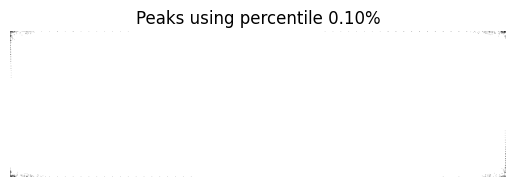

In [47]:
# rilevo i picchi di magnitudine
p = 0.1/100  # percentile
image_fft_abs = image_fft.flatten().abs()
image_fft_abs_sort = torch.sort(image_fft_abs, descending=True)
threshold = image_fft_abs_sort.values[int(p * image_fft_abs.numel())]
image_fft_abs_thresholded = image_fft_abs <= threshold

# cambio tipo in float
image_fft_abs_thresholded = image_fft_abs_thresholded.to(torch.float32)

# visualizzo i picchi
plt.figure()
plt.imshow(image_fft_abs_thresholded.reshape(image_fft.shape), cmap='gray')
plt.axis('off')
plt.title(f'Peaks using percentile {p*100:.2f}%')

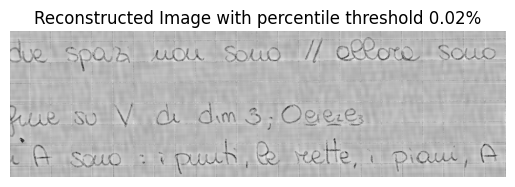

In [48]:
# annullo i picchi
image_fft_new = image_fft * image_fft_abs_thresholded.reshape(image_fft.shape)

# ricostruisco l'immagine
image_reconstructed = torch.fft.ifft2(image_fft_new, norm='ortho').real
image_reconstructed = (image_reconstructed - image_reconstructed.min()) / (image_reconstructed.max() - image_reconstructed.min())

# visualizzo l'immagine ricostruita
plt.figure()
plt.imshow(image_reconstructed, cmap='gray')
plt.axis('off')
plt.title('Reconstructed Image with percentile threshold 0.02%')
plt.savefig('reconstructed.png', dpi=600)

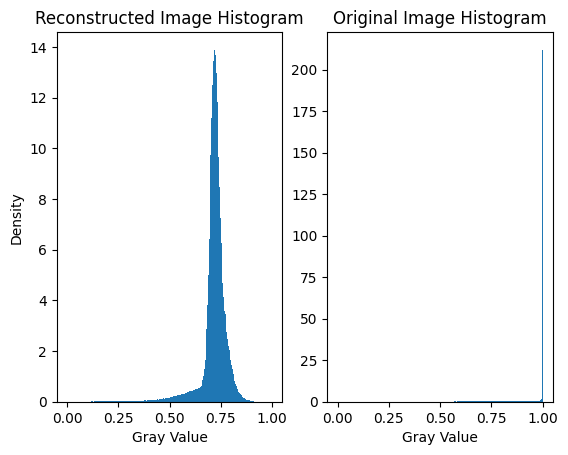

In [49]:
# mostro l'istogramma dei valori di grigio di image_torch
plt.figure()
image_reconstructed = (image_reconstructed - image_reconstructed.min()) / (image_reconstructed.max() - image_reconstructed.min())
plt.subplot(1,2,1)
plt.hist(image_reconstructed.to('cpu').flatten(), bins=256, density=True)
plt.title('Reconstructed Image Histogram')
plt.xlabel('Gray Value')
plt.ylabel('Density')
#plt.subplot(1,2,1)
plt.subplot(1,2,2)
image_normalized = (np.array(image) - np.array(image).min()) / (np.array(image).max() - np.array(image).min())
plt.hist(image_normalized.flatten(), bins=256, density=True)
plt.title('Original Image Histogram')
plt.xlabel('Gray Value')
plt.savefig("diagrams.png", dpi=600)


Text(0.5, 1.0, 'Thresholded Image')

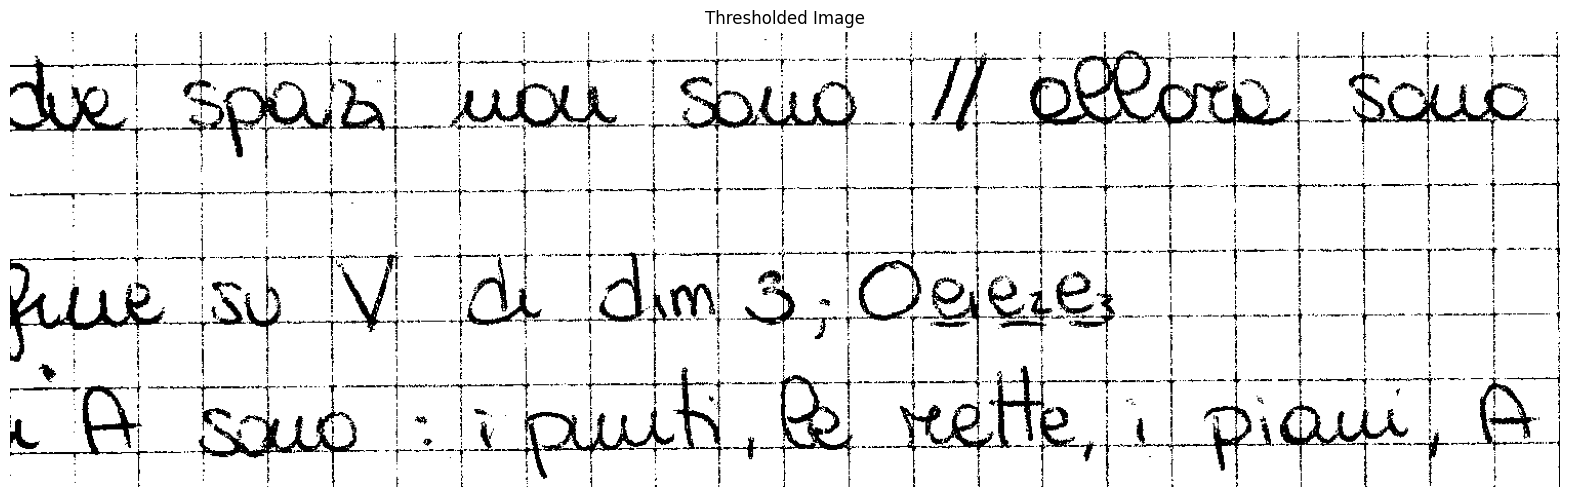

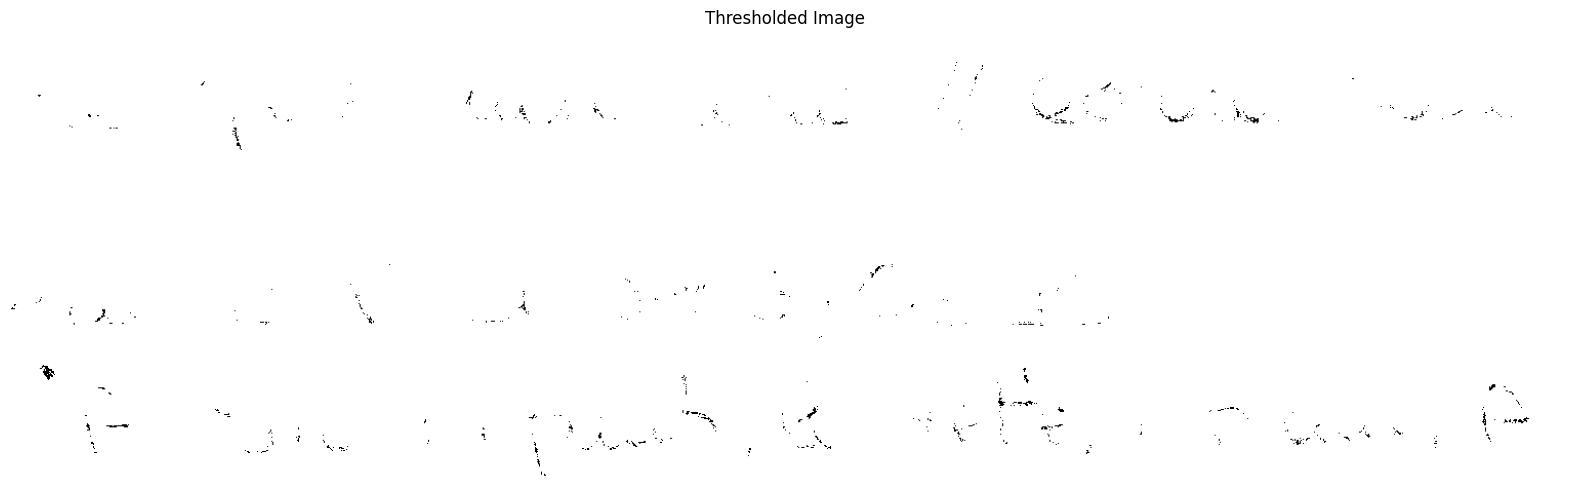

In [50]:
# imposto un threshold e mostro nell'immagine quali pixel superano il threshold
min,max = 0.2, 0.8
image_torch = torch.from_numpy(np.array(image)) / 255.0
# bianco qui -> bianco originale (dello sfondo) allora ok
plt.figure(figsize=(20, 10))
plt.imshow(image_torch > max, cmap='gray')
plt.axis('off')
plt.title('Thresholded Image')
# nero qui -> nero originale (delle scritte) allora ok
plt.figure(figsize=(20, 10))
plt.imshow(image_torch >= min, cmap='gray')
plt.axis('off')
plt.title('Thresholded Image')

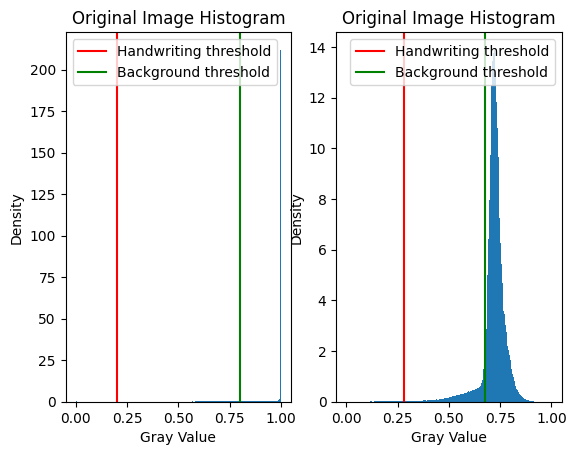

In [51]:
# mostro nel diagramma i valori di grigio dell'immagine originale evidenziando in rosso quelli inferiori a min e in verde quelli superiori a max
plt.subplot(1,2,1)
plt.hist(image_torch.flatten(), bins=256, density=True)
plt.title('Original Image Histogram')
plt.xlabel('Gray Value')
plt.ylabel('Density')
plt.axvline(min, color='red', label='Handwriting threshold')
plt.axvline(max, color='green', label='Background threshold')
plt.legend()
plt.subplot(1,2,2)
# conto quanti pixel in image_torch sono inferiori a min
b_cnt = torch.count_nonzero(image_torch <= min) / image_torch.numel()
# conto quanti pixel in image_torch sono superiori a max
w_cnt = torch.count_nonzero(image_torch >= max) / image_torch.numel()
# determino i trashold per il clamp
h_b = torch.quantile(image_reconstructed, b_cnt)
h_w = torch.quantile(image_reconstructed, 1 - w_cnt)
plt.hist(image_reconstructed.flatten(), bins=256, density=True)
plt.title('Original Image Histogram')
plt.xlabel('Gray Value')
plt.ylabel('Density')
plt.axvline(h_b, color='red', label='Handwriting threshold')
plt.axvline(h_w, color='green', label='Background threshold')
plt.legend()
plt.savefig('thresholded_histogram.png', dpi=600)

In [52]:
# normalize image
min,max = 0.2, 0.8
# conto quanti pixel in image_torch sono inferiori a min
b_cnt = torch.count_nonzero(image_torch <= min) / image_torch.numel()
# conto quanti pixel in image_torch sono superiori a max
w_cnt = torch.count_nonzero(image_torch >= max) / image_torch.numel()
# determino i trashold per il clamp
h_b = torch.quantile(image_reconstructed, b_cnt)
h_w = torch.quantile(image_reconstructed, 1 - w_cnt)


image_new = (image_reconstructed - h_b) / (h_w - h_b)
image_new = torch.clamp(image_new, 0, 1)

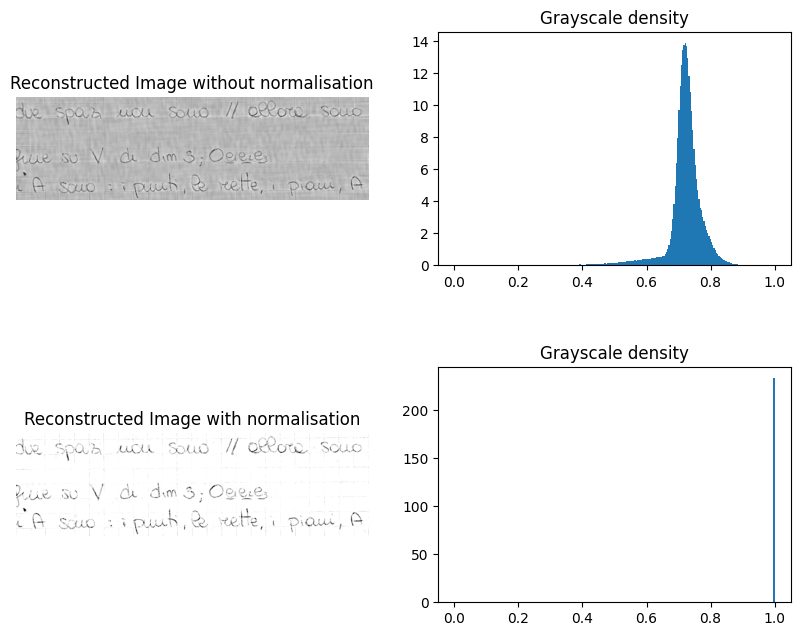

In [53]:

# visualizzo l'immagine ricostruita
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(image_reconstructed, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('Reconstructed Image without normalisation')

# mostro il plot dei grigi presenti
plt.subplot(2, 2, 2, aspect=0.05)
plt.hist(image_reconstructed.flatten(), bins=256, density=True)
plt.title('Grayscale density')

plt.subplot(2, 2, 3)
plt.imshow(image_new, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('Reconstructed Image with normalisation')
plt.subplot(2, 2, 4, aspect=0.003)
plt.hist(image_new.flatten(), bins=256, density=True)
plt.title('Grayscale density')

plt.savefig('first_reconstruct.png', dpi=1200)